# GEOPH 559: Geophysical Fluid Dynamics
### Modeling Geophysical Flows: 1-D Shallow Water Equations Modeling

The purpose of this notebook is to provide an introduction to numerical modeling of geophysical flows. In particular, this notebook illustrates a finite difference solution to the 1-D shallow water equations (SWEs). This serves as an approachable illustration of the numerical solution to a simplified version of the Navier-Stokes equation that is nevertheless realistic enough that it describes well phenomena observed in large fluid bodies (e.g., the ocean, atmosphere, and large lakes). To recapitulate, we arrived at the SWEs by making the following assumptions from the full 3D Navier-Stokes equations that apply to large-scale flows where the horizontal length scale is much greater than the vertical depth:

1. Hydrostatic balance in the vertical direction.

$$
\frac{\partial p}{\partial z} = -\rho g
$$

2. Vertically uniform horizontal velocity:

$$
u(x,y,z,t) \approx \bar{u}(x,y,t)
$$

3. Depth integration of the continuity and momentum equations vertically from the bottom of the bed to the free surface, which yields depth-averaged equations of fluid motion. 

In one dimension, these equations correspond to:

* Mass conservation/continuity equation:
$$
\frac{\partial h}{\partial t} + \frac{\partial (hu)}{\partial x} = 0
$$

* Conservation of momentum:
$$
\frac{Du}{Dt} + g\frac{\partial h}{\partial x} = \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + g\frac{\partial h}{\partial x} = 0
$$

For the purposes of numerical stability, we will use the MacCormack predictor-corrector method to develop a finite difference solution to the SWEs. We will use an initial condition consistent with an initial Gaussian wave present in our modeling domain and uniform, zero velocities everywhere. Boundary conditions at both ends of the domain coincide with a reflection boundary condition so that waves that hit the boundaries will reflect perfectly back into the domain. Think of this as how water in a bathtub might behave. 

### 1. Import Libraries and Define Physical and Computational Domain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
%matplotlib inline

# ----------------------------
# Physical parameters
# ----------------------------
g = 9.81   # gravitational acceleration (m/s^2)
L = 50000 # domain length (m)
nx = 500  # number of grid points
dx = L / (nx - 1)
x = np.linspace(0, L, nx)
h_bg = 100     # background depth of water body (m)

DiffusionOn = True # Use to add diffusion to velocity
nu = 10e-1 # Eddy diffusion (m^2/s)

# ----------------------------
# Time parameters
# ----------------------------
dt = 1.0  # time step (s)
T  = 36000 # Duration of run (s)
nt = int(T/dt) # number of time steps
t  = dt*np.arange(nt+1) # create a time vector for plotting
output_every = 100 # Frame output interval for animation


### 2. Define Initial Conditions

Text(0.5, 0, 'Distance')

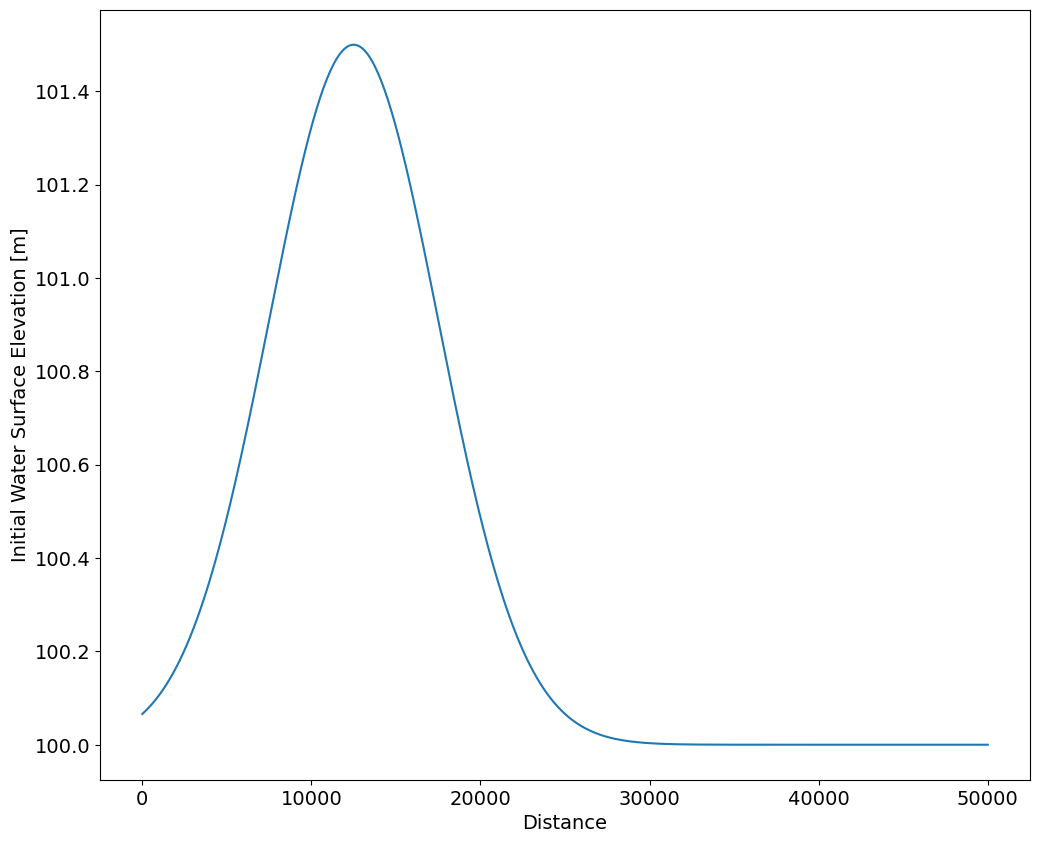

In [ ]:
# ----------------------------
# Initial condition
# ----------------------------
h0 = h_bg * np.ones(nx) # Background depth, distributed (m)
u0 = np.zeros(nx)   # initial velocity (m/s)

# Add a small Gaussian perturbation in water height
perturb_center = L/4
perturb_width = 5e3
perturb_height = 1.5

h0 += perturb_height * np.exp(-((x - perturb_center)**2) / (2 * perturb_width**2))

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12,10))
plt.plot(x,h0)
plt.ylabel('Initial Water Surface Elevation [m]')
plt.xlabel('Distance')
plt.show()



### 3. Initialize Storage Containers

In [3]:
# Initialize arrays
h = h0
u = u0

h_record = np.zeros((nx,nt+1))
u_record = np.zeros((nx,nt+1))

### 4. Loop Through Simulation Time

In [4]:
# ----------------------------
# MacCormack Method
# ----------------------------
save_counter = 0

h_record[:,0] = h
u_record[:,0] = u

alpha = dt/dx

for n in range(nt):
    # Predictor step
    h = h_record[:,n]
    u = u_record[:,n]
    h_pred = np.zeros((nx))
    u_pred = np.zeros((nx))
    h_corr = np.zeros((nx))
    u_corr = np.zeros((nx))
    
    # Avoid indexing errors
    for i in range(nx - 1):
        h_pred[i] = h[i] - alpha*(h[i+1] * u[i+1] - h[i] * u[i])
        u_pred[i] = u[i] - alpha*u[i]*(u[i+1] - u[i]) - g*alpha*(h[i+1]-h[i])

    # Corrector step
    for i in range(1, nx):
        h_corr[i] = 0.5*(h[i]+h_pred[i] - alpha*(u_pred[i]*h_pred[i] - u_pred[i-1]*h_pred[i-1]))
        u_corr[i] = 0.5*(u[i]+u_pred[i] - alpha*u_pred[i]*(u_pred[i] - u_pred[i-1]) - g*alpha*(h_pred[i]-h_pred[i-1]))
    
    cfl = np.max(np.abs(u_corr) + np.sqrt(g*h_corr))*dt/dx
    if cfl > 1:
        print(f'Exceeding CFL limit. CFL = {cfl:.2f} at time step {n}. Consider reducing dt.')

    # Reflective boundary conditions
    h_corr[0] = h_corr[1]
    h_corr[-1] = h_corr[-2]
    u_corr[0] = -u_corr[1]
    u_corr[-1] = -u_corr[-2]

    if (DiffusionOn == True):
        u_diff = np.zeros((nx))
        if((2*nu*dt)/(dx**2) > 1):
            print(f'Diffusion stability limit reached {(2*nu*dt)/(dx**2):.2f}. Consider reducing timestep, increasing spatial step, or reducing eddy diffusivity')
        for i in range(1, nx - 1):
            u_diff[i] = u_corr[i] + nu * dt / dx**2 * (u_corr[i+1] - 2*u_corr[i] + u_corr[i-1])
        u_corr = u_diff
    
    # Reflective boundary conditions
    h_corr[0] = h_corr[1]
    h_corr[-1] = h_corr[-2]
    u_corr[0] = -u_corr[1]
    u_corr[-1] = -u_corr[-2]
    
    h_record[:,n+1] = h_corr
    u_record[:,n+1] = u_corr


## 5. Create an Animation of Water Surface Elevation

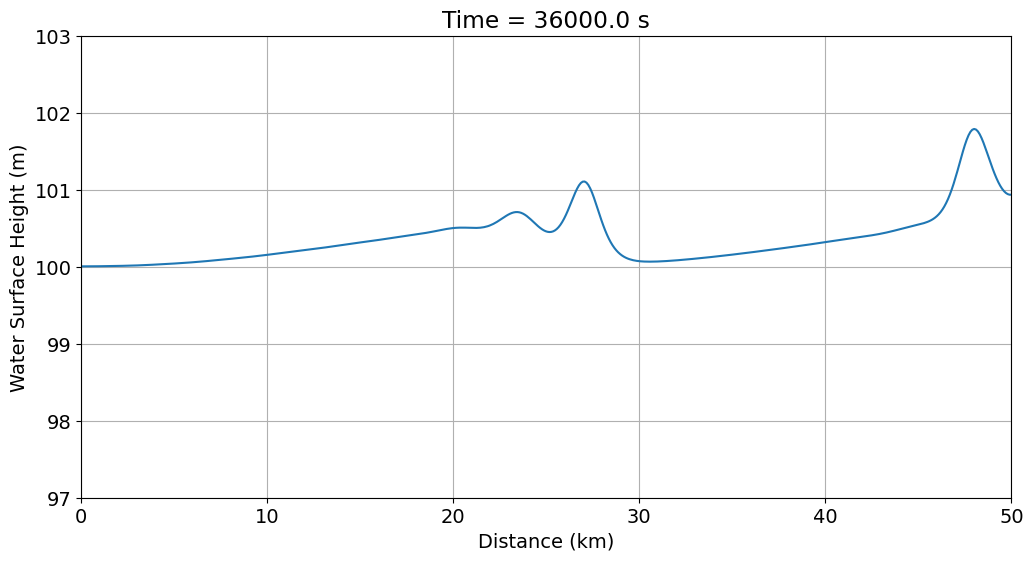

In [5]:
# ----------------------------
# Animation
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 6))
line, = ax.plot(x/1e3 , h_record[:,0], label='Water Height')
ax.set_ylim(h_bg - 2*perturb_height, h_bg + 2*perturb_height)
ax.set_xlim(0, x.max()/1e3)
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Water Surface Height (m)')
ax.set_title('1D Shallow Water Waves (Reflective Boundaries)')
ax.grid(True)

def update(frame):
    line.set_ydata(h_record[:,frame])
    ax.set_title(f"Time = {frame*dt:.1f} s")
    return line,

anim = FuncAnimation(fig, update, frames=range(0,h_record.shape[1],output_every),interval=50)
anim.save("swe_animation.gif", writer=PillowWriter(fps=60))
plt.show()

### 6. Plot Water Surface Elevation at a Location Through Time

For purposes of illustration, it is helpful to plot how the water surface elevation at a point in the domain change as a function of time. Here we can see the influence of waves as they move in both directions and, sometimes, interact with one another. In the plot below, we're looking at a time series plot of water surface elevation versus time at the point exactly in the middle of the domain. 

Text(0.5, 0, 'Time (s)')

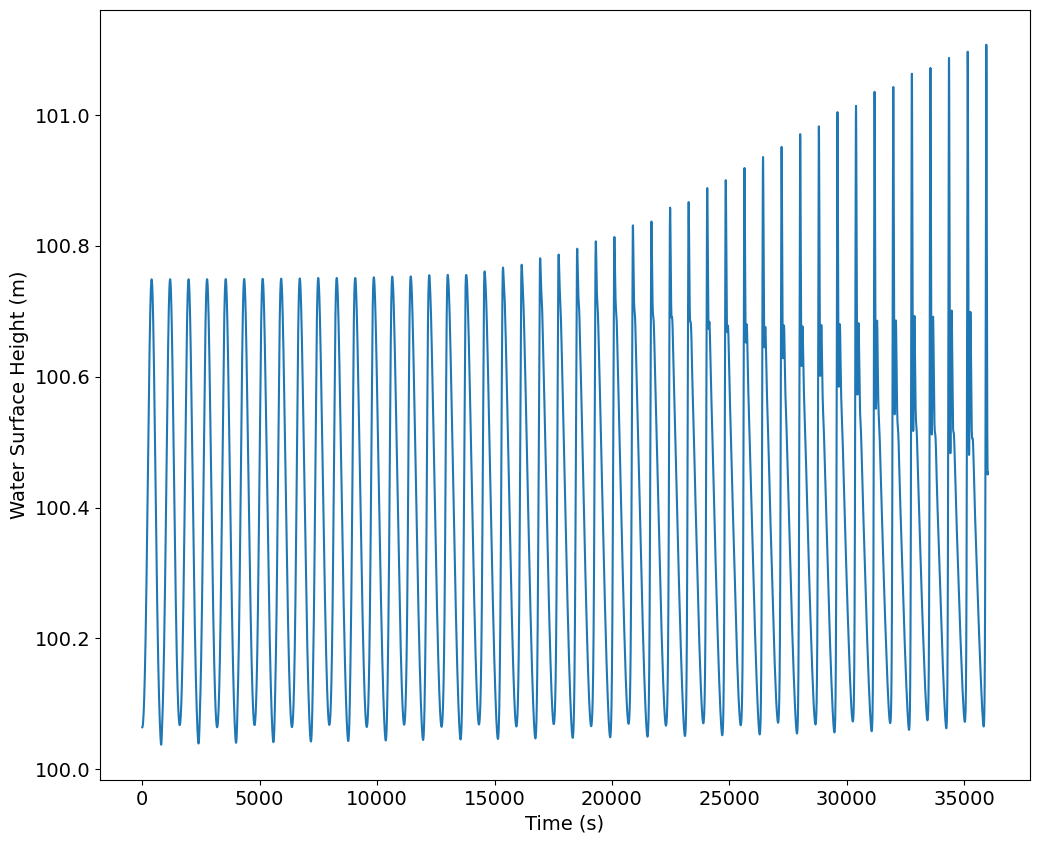

In [ ]:
# Plot wave heights through time in the middle of the domain
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12,10))
plt.plot(t,h_record[int(nx/2),:])
plt.ylabel('Water Surface Height (m)')
plt.xlabel('Time (s)')
plt.show()

### 7. Animate the Evolution of Wave Height and Velocity

We also want to create an animated plot the evolution of the water surface elevation and velocity versus time. This takes the form of a longitudinal profile of water surface elevation overlaid on a heatmap of the velocity distribution within the domain. The colorbar is a diverging colorbar wherein positive velocities (i.e., velocities from left-to-right) are shown in blue and negative velocities (i.e., velocities from right-to-left) are shown in red. 

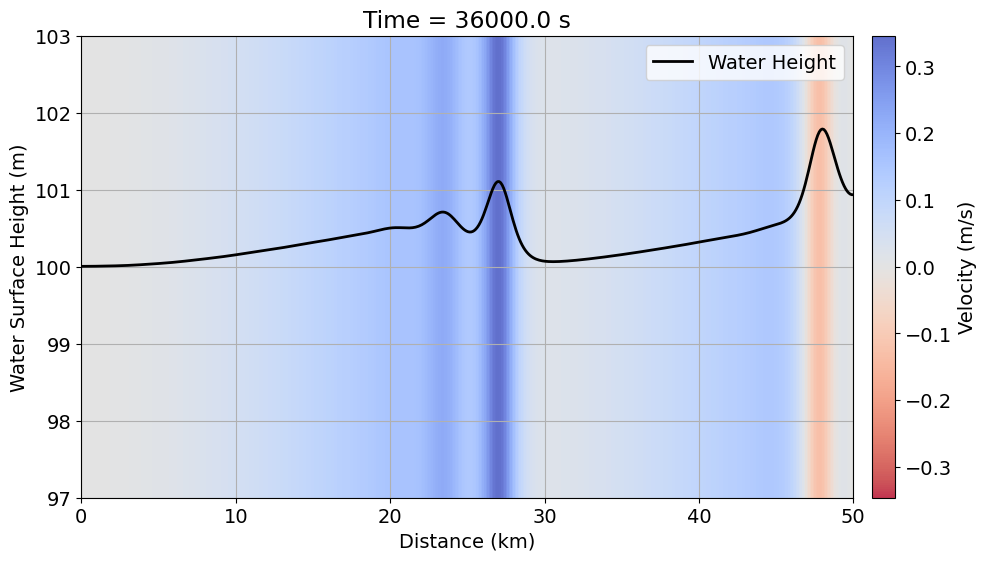

In [7]:
# Transpose h_record and u_record if needed
nt = h_record.shape[1]
nx = h_record.shape[0]
H = h_record.T  # shape: (nt, nx)
U = u_record.T  # shape: (nt, nx)

# Global min/max velocity for color scale
vmin = -np.max(np.abs(U))
vmax = np.max(np.abs(U))

# ----------------------------
# Animation: height + velocity colormap
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# Initialize velocity colormap (1 row of U for current time)
vmin = -np.max(np.abs(U))
vmax = np.max(np.abs(U))
velocity_img = ax.imshow(U[0][np.newaxis, :],
                         extent=[x.min()/1e3, x.max()/1e3, h_bg - 2*perturb_height, h_bg + 2*perturb_height],
                         aspect='auto',
                         cmap='coolwarm_r',
                         vmin=vmin,
                         vmax=vmax,
                         interpolation='nearest',
                         alpha=0.8)

# Add colorbar
cbar = fig.colorbar(velocity_img, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Velocity (m/s)")

# Water height line
line, = ax.plot(x/1e3, H[0], color='black', linewidth=2, label='Water Height')

# Aesthetic setup
ax.set_xlim(x.min()/1e3, x.max()/1e3)
ax.set_ylim(h_bg - 2*perturb_height, h_bg + 2*perturb_height)
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Water Surface Height (m)')
ax.set_title('Shallow Water Wave + Velocity Field')
ax.legend()
ax.grid(True)

# Update function
def update(frame):
    line.set_ydata(H[frame])
    velocity_img.set_data(U[frame][np.newaxis, :])
    ax.set_title(f"Time = {frame * dt:.1f} s")
    return line, velocity_img

# Animate
anim = FuncAnimation(fig, update, frames=range(0, nt, output_every), interval=50)
anim.save("swe_overlay_velocity.gif", writer=PillowWriter(fps=60))
plt.show()
